In [1]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error


In [2]:
import psycopg2

# Connect to the PostgreSQL database
conn = psycopg2.connect(
    host="...",
    database="...",
    user="...",
    password="..."
)

# Create a cursor object to interact with the database
cursor = conn.cursor()

# Execute a SELECT query to fetch data from a table
query = "SELECT * FROM station_data_hour WHERE location_id = 238016"
cursor.execute(query)

# Fetch all rows from the result set
rows = cursor.fetchall()

# Get the column names from the cursor description
columns = [desc[0] for desc in cursor.description]

# Create a Pandas DataFrame with the fetched data and column names
df = pd.DataFrame(rows, columns=columns)

# Close the cursor and connection
cursor.close()
conn.close()

# Print the DataFrame
print(df.head())


   location_id location_friendlyname location_friendlycode  \
0       238016      Opatija Verdieva           HRHEP-51028   
1       238016      Opatija Verdieva           HRHEP-51028   
2       238016      Opatija Verdieva           HRHEP-51028   
3       238016      Opatija Verdieva           HRHEP-51028   
4       238016      Opatija Verdieva           HRHEP-51028   

  location_address_cityname  location_address_postnumber  \
0                   Opatija                        51410   
1                   Opatija                        51410   
2                   Opatija                        51410   
3                   Opatija                        51410   
4                   Opatija                        51410   

  location_address_streetname location_address_housenumber  \
0            Giuseppea Verdia                           bb   
1            Giuseppea Verdia                           bb   
2            Giuseppea Verdia                           bb   
3            Giuse

In [4]:
# Provide the dataframe from database
data_stations = df.copy()

# Get the user-provided value to filter on
location_id_opatija = 238016        # Opatija
location_id_zg = 140631             # ZG Autobusni K
location_id_os = 171122             # Osijek

In [5]:
def filter_csv_by_first_column(df, value):
    '''inputs: csv_file - file with measurements (from database), value - ID'''

    # Filter rows based on the first column value, save the name of the station
    filtered_df = df[df.iloc[:, 0] == value]
    name = str(filtered_df.iloc[0, 1])
    print('Station: ', name)

    # eliminate the columns 1 to 6 that pertain to the location (address, street number etc.)
    filtered_df = filtered_df.iloc[:, 7:]
    filtered_df = filtered_df.drop(columns = "charging_minutes", axis = 1)
    filtered_df = filtered_df.drop(columns = "congested_connectors", axis = 1)

    return filtered_df, name

In [6]:
# Call the function to filter the CSV
filtered_data_op, name1  = filter_csv_by_first_column(data_stations, location_id_opatija)
#filtered_data_zg, name2 = filter_csv_by_first_column(data_stations, location_id_zg)
#filtered_data_os, name3 = filter_csv_by_first_column(data_stations, location_id_os)

Station:  Opatija Verdieva


In [7]:
def expand_data(dataframe, name):
    '''inputs: original dataframe with values for ONE station'''

    dataframe_copy = dataframe.copy()

    # create new dataframe with index as every hour
    dataframe_copy['Time'] = pd.to_datetime(dataframe_copy['charging_hour'], format='%Y-%m-%d %H:%M:%S').dt.tz_localize(None)

    start_index = dataframe_copy.iloc[0, -1].date() #starting point is the day of the first index
    end_index = dataframe_copy.iloc[-1, -1].date() # ending pojnt is the day of the last index
    #end_index = pd.to_datetime("2023-5-30 00:00:00")
    indices = pd.date_range(start_index, end_index, freq='1H')

    dataframe_copy.set_index('Time', inplace=True)

    print(dataframe.describe())
    #dataframe.describe().to_csv('Opis podataka Osijek.csv', sep=';')

    # new_dataframe is a dataframe that is expanded with zero values
    new_dataframe = pd.DataFrame(index=indices, data=dataframe_copy)

    # important features (charging_minutes, consumption, utilization) are filled with zeros
    # other values (that are the same for each time step) are copied - like connector_count and location_accesstype
    new_dataframe['location_accesstype_title'] = new_dataframe['location_accesstype_title'].fillna(dataframe_copy['location_accesstype_title'][0])
    new_dataframe['charging_hour'] = new_dataframe['charging_hour'].fillna(np.nan)
    # charging_hour column is filled with Nan values because it will be later dropped and is not necessary
    new_dataframe['utilization'] = new_dataframe['utilization'].fillna(0.0)
    new_dataframe['connector_count'] = new_dataframe['connector_count'].fillna(dataframe_copy['connector_count'][0])
    #new_dataframe['congested_connectors'] = new_dataframe['congested_connectors'].fillna(0.0)
    new_dataframe['energy_consumption'] = new_dataframe['energy_consumption'].fillna(0.0)
    #new_dataframe['charging_minutes'] = new_dataframe['charging_minutes'].fillna(0.0)
    #for i in range(1, n_steps+1):
    #    new_dataframe[f'utilization(t-{i})'] = new_dataframe[f'utilization(t-{i})'].fillna(0.0)
    #    new_dataframe[f'energy_consumption(t-{i})'] = new_dataframe[f'energy_consumption(t-{i})'].fillna(0.0)

    # new_dataframe is then save to the .csv file
    # new_dataframe.to_csv(r'C:\Users\ZVNE\OneDrive - fer.hr\projekti\E-Mobility Grčka\station data expanded ' + str(name) + '.csv', sep=';')

    # expanded dataframe is returned
    return new_dataframe




In [8]:
expanded_data_op = expand_data(filtered_data_op, name1)
# expanded_data_zg = expand_data(filtered_data_zg, name2)
# expanded_data_os = expand_data(filtered_data_os, name3)
expanded_data_op

       utilization  connector_count  energy_consumption
count  1627.000000           1627.0         1627.000000
mean     42.302295              2.0            4.399252
std      21.296356              0.0            3.724568
min       0.000000              2.0            0.000000
25%      27.500000              2.0            1.346151
50%      50.000000              2.0            3.204889
75%      50.000000              2.0            6.799889
max     100.000000              2.0           21.649773


,location_accesstype_title,charging_hour,utilization,connector_count,energy_consumption
2021-08-11 00:00:00,Public access - Free access,NaT,0.0,2.0,0.0
2021-08-11 01:00:00,Public access - Free access,NaT,0.0,2.0,0.0
2021-08-11 02:00:00,Public access - Free access,NaT,0.0,2.0,0.0
2021-08-11 03:00:00,Public access - Free access,NaT,0.0,2.0,0.0
2021-08-11 04:00:00,Public access - Free access,NaT,0.0,2.0,0.0
...,...,...,...,...,...
2022-10-29 20:00:00,Public access - Free access,NaT,0.0,2.0,0.0
2022-10-29 21:00:00,Public access - Free access,NaT,0.0,2.0,0.0
2022-10-29 22:00:00,Public access - Free access,NaT,0.0,2.0,0.0
2022-10-29 23:00:00,Public access - Free access,NaT,0.0,2.0,0.0


In [9]:
data = expanded_data_op[['utilization']]
data

,utilization
2021-08-11 00:00:00,0.0
2021-08-11 01:00:00,0.0
2021-08-11 02:00:00,0.0
2021-08-11 03:00:00,0.0
2021-08-11 04:00:00,0.0
...,...
2022-10-29 20:00:00,0.0
2022-10-29 21:00:00,0.0
2022-10-29 22:00:00,0.0
2022-10-29 23:00:00,0.0


In [10]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [57]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps, n_future):
    df = dc(df)

    #df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'util(t-{i})'] = df['utilization'].shift(i)
    
    for i in range(0, n_future):
        df[f'utilization(t+{i})'] = df['utilization'].shift(-i)
    
    df.dropna(inplace=True)
    df.drop(columns='utilization', inplace=True)

    return df

lookback = 24
future_steps = 24
shifted_df = prepare_dataframe_for_lstm(data, lookback, future_steps)
shifted_df

,util(t-1),util(t-2),util(t-3),util(t-4),util(t-5),util(t-6),util(t-7),util(t-8),util(t-9),util(t-10),...,utilization(t+14),utilization(t+15),utilization(t+16),utilization(t+17),utilization(t+18),utilization(t+19),utilization(t+20),utilization(t+21),utilization(t+22),utilization(t+23)
2021-08-12 00:00:00,0.0,40.833333,50.000000,7.500000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,31.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-08-12 01:00:00,0.0,0.000000,40.833333,50.000000,7.500000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-08-12 02:00:00,0.0,0.000000,0.000000,40.833333,50.000000,7.500000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-08-12 03:00:00,0.0,0.000000,0.000000,0.000000,40.833333,50.000000,7.5,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-08-12 04:00:00,0.0,0.000000,0.000000,0.000000,0.000000,40.833333,50.0,7.5,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-28 21:00:00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,23.333333,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-10-28 22:00:00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,23.333333,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-10-28 23:00:00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-10-29 00:00:00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
shifted_df['utilization'][1:25].reset_index(drop=True).plot()
shifted_df['util(t-1)'][:24].reset_index(drop=True).plot()
shifted_df['utilization(t+2)'][3:27].reset_index(drop=True).plot()
#shifted_df['util(t+1)'][:50].plot()

KeyError: 'utilization'

In [347]:
x = shifted_df.filter(regex='t-')
x

,util(t-1),util(t-2),util(t-3),util(t-4),util(t-5),util(t-6),util(t-7),util(t-8),util(t-9),util(t-10),...,util(t-15),util(t-16),util(t-17),util(t-18),util(t-19),util(t-20),util(t-21),util(t-22),util(t-23),util(t-24)
2021-08-12 00:00:00,0.0,40.833333,50.000000,7.500000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-08-12 01:00:00,0.0,0.000000,40.833333,50.000000,7.500000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-08-12 02:00:00,0.0,0.000000,0.000000,40.833333,50.000000,7.500000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-08-12 03:00:00,0.0,0.000000,0.000000,0.000000,40.833333,50.000000,7.5,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-08-12 04:00:00,0.0,0.000000,0.000000,0.000000,0.000000,40.833333,50.0,7.5,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-28 21:00:00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,23.333333,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-10-28 22:00:00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,23.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-10-28 23:00:00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-10-29 00:00:00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [348]:
shifted_df.columns

Index(['util(t-1)', 'util(t-2)', 'util(t-3)', 'util(t-4)', 'util(t-5)',
       'util(t-6)', 'util(t-7)', 'util(t-8)', 'util(t-9)', 'util(t-10)',
       'util(t-11)', 'util(t-12)', 'util(t-13)', 'util(t-14)', 'util(t-15)',
       'util(t-16)', 'util(t-17)', 'util(t-18)', 'util(t-19)', 'util(t-20)',
       'util(t-21)', 'util(t-22)', 'util(t-23)', 'util(t-24)',
       'utilization(t+0)', 'utilization(t+1)', 'utilization(t+2)',
       'utilization(t+3)', 'utilization(t+4)', 'utilization(t+5)',
       'utilization(t+6)', 'utilization(t+7)', 'utilization(t+8)',
       'utilization(t+9)', 'utilization(t+10)', 'utilization(t+11)',
       'utilization(t+12)', 'utilization(t+13)', 'utilization(t+14)',
       'utilization(t+15)', 'utilization(t+16)', 'utilization(t+17)',
       'utilization(t+18)', 'utilization(t+19)', 'utilization(t+20)',
       'utilization(t+21)', 'utilization(t+22)', 'utilization(t+23)'],
      dtype='object')

In [349]:
y = shifted_df.filter(regex='utilization')
y

,utilization(t+0),utilization(t+1),utilization(t+2),utilization(t+3),utilization(t+4),utilization(t+5),utilization(t+6),utilization(t+7),utilization(t+8),utilization(t+9),...,utilization(t+14),utilization(t+15),utilization(t+16),utilization(t+17),utilization(t+18),utilization(t+19),utilization(t+20),utilization(t+21),utilization(t+22),utilization(t+23)
2021-08-12 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,31.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-08-12 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.833333,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-08-12 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.833333,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-08-12 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.833333,0.000000,41.666667,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-08-12 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.833333,0.000000,41.666667,50.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-28 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-10-28 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-10-28 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-10-29 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:>

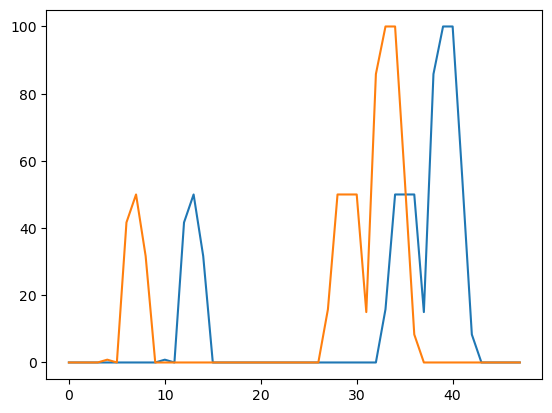

In [350]:
y['utilization(t+0)'][0:48].reset_index(drop=True).plot()
y['utilization(t+6)'][:48].reset_index(drop=True).plot()
#shifted_df['utilization(t+2)'][3:27].reset_index(drop=True).plot()

In [351]:
y_np = y.to_numpy()
x_np = x.to_numpy()
y_np

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [352]:
x_np

array([[ 0.        , 40.83333333, 50.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 40.83333333, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [353]:
data

,utilization
2021-08-11 00:00:00,0.0
2021-08-11 01:00:00,0.0
2021-08-11 02:00:00,0.0
2021-08-11 03:00:00,0.0
2021-08-11 04:00:00,0.0
...,...
2022-10-29 20:00:00,0.0
2022-10-29 21:00:00,0.0
2022-10-29 22:00:00,0.0
2022-10-29 23:00:00,0.0


In [354]:
y_np.shape

(10634, 24)

In [355]:
x_np.shape

(10634, 24)

In [356]:
X = x_np.copy()
Y = y_np.copy()

X.shape, Y.shape

((10634, 24), (10634, 24))

In [357]:
X

array([[ 0.        , 40.83333333, 50.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 40.83333333, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [358]:
split_index_train = int(len(X) * 0.8)
split_index_test = int(len(X) * 0.1)

split_index

10102

In [359]:
X_train = X[:split_index_train]
X_val = X[split_index_train:split_index_test + split_index_train]
X_test = X[split_index_test + split_index_train:]

y_train = Y[:split_index_train]
y_val = Y[split_index_train:split_index_test + split_index_train]
y_test = Y[split_index_test + split_index_train:]


X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((8507, 24), (1063, 24), (1064, 24), (8507, 24), (1063, 24), (1064, 24))

In [360]:
X_train = X_train.reshape((-1, lookback, 1))
X_val = X_val.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, future_steps, 1))
y_val = y_val.reshape((-1, future_steps, 1))
y_test = y_test.reshape((-1, future_steps, 1))

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((8507, 24, 1),
 (1063, 24, 1),
 (1064, 24, 1),
 (8507, 24, 1),
 (1063, 24, 1),
 (1064, 24, 1))

In [361]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_val = torch.tensor(X_val).float()
y_val = torch.tensor(y_val).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([8507, 24, 1]),
 torch.Size([1064, 24, 1]),
 torch.Size([8507, 24, 1]),
 torch.Size([1064, 24, 1]))

In [362]:
train_size = y_train.shape[0]
val_size = y_val.shape[0]
test_size = y_test.shape[0]

In [363]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [364]:
from torch.utils.data import DataLoader

batch_size = 512

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = False)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle = False)

In [365]:
for x,y in train_loader:
    print(x.to(device).shape, y.to(device).shape)
    break
    
# this is a random check of data shape

torch.Size([512, 24, 1]) torch.Size([512, 24, 1])


In [366]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([512, 24, 1]) torch.Size([512, 24, 1])


In [367]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, :, :])
        return out


In [368]:
# Function to calculate the mean squared error
def calculate_mse(y_true, y_pred):
    return mean_squared_error(y_true.detach().squeeze().numpy(), y_pred.detach().squeeze().numpy())


In [369]:
# these are additional lists and dataframes that are used to save results
train_loss_list = []
train_mse_list = []
test_loss_list = []
test_mse_list = []
epoch_list = []
predicted_values_consumption = pd.DataFrame()
predicted_values_utilization = pd.DataFrame()
real_values_consumption = pd.DataFrame()
real_values_utilization = pd.DataFrame()

pred_consumption_test = pd.DataFrame()
pred_utilization_test = pd.DataFrame()
real_consumption_test = pd.DataFrame()
real_utilization_test = pd.DataFrame()

In [370]:
learning_rate = 0.05
num_epochs = 1000

model = LSTM(1, 64, 2)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

counter = 0

for epoch in range(num_epochs):
    
    train_loss = 0.0
    val_loss = 0.0
    train_mse = 0.0
    val_mse = 0.0
    
    # Initialize hidden state
    #hidden = None
    
    # Training
    model.train()
    for inputs, labels in train_loader:
        #print(inputs.unsqueeze(2).shape)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        train_mse += calculate_mse(labels, outputs)
        #print('Train loss:', loss.item())
    

    # Testing
    model.eval()
    
    # *_pom1 is a list that is used for storing values related to the energy consumption
    # *_pom2 is a list that is used for storing values related to the utilization
    predicted_values_pom1 = []
    predicted_values_pom2 = []
    real_values_pom1 = []
    real_values_pom2 = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            # print('Outputs shape: ', outputs.squeeze().shape)
            predicted_values_pom1 += outputs.squeeze().numpy()[:, 0].tolist()
            predicted_values_pom2 += outputs.squeeze().numpy()[:, 1].tolist()
            real_values_pom1 += labels.numpy()[:, 0].tolist()
            real_values_pom2 += labels.numpy()[:, 1].tolist()
            val_loss += loss.item() * inputs.size(0)
            val_mse += calculate_mse(labels, outputs)
            
    if epoch == 0:
        real_values_consumption['Epoch ' + str(epoch)] = real_values_pom1
        real_values_utilization['Epoch ' + str(epoch)] = real_values_pom2
        
        # in the first epoch, the calculated losses are considered minimal -> in later epochs it is checked whether the loss is reducing
        val_loss_old = (val_loss/val_size)
        min_val_loss = val_loss_old
        min_weights = model.state_dict()
        
    if epoch > 0:
        val_loss_new = val_loss/val_size
        if val_loss_new > min_val_loss: # some kind of an Early Stopping callback
            counter += 1
        else:
            predicted_values_consumption['The best epoch'] = predicted_values_pom1
            predicted_values_utilization['The best epoch'] = predicted_values_pom2
            min_val_loss = val_loss_new
            
            # if the loss is reducing, current weights and model are saved
            min_weights = model.state_dict()
            best_model = model
            counter = 0
            print('Currently best epoch: ', epoch)
            print('Minimum validation loss: ', min_val_loss)
        
    if epoch%20 == 0:
        # Print training and test errors
        print(f"Epoch {epoch}/{num_epochs} - Training Loss: {train_loss/train_size:.4f} - Val Loss: {val_loss/val_size:.4f} - Train MSE: {train_mse/val_size:.4f} - Val MSE: {val_mse/val_size:.4f}")
        train_loss_list.append(train_loss/train_size)
        train_mse_list.append(train_mse/train_size)
        test_loss_list.append(val_loss/val_size)
        test_mse_list.append(val_mse/val_size)
        epoch_list.append(epoch)
        predicted_values_consumption['Epoch ' + str(epoch)] = predicted_values_pom1
        predicted_values_utilization['Epoch ' + str(epoch)] = predicted_values_pom2
        
    if counter == 30: 
        # If the loss hasn't reduced for 30 epochs, stop training
        print(f"[Early stopping] Epoch {epoch}/{num_epochs} - Train MSE: {train_mse/train_size:.4f} - Val MSE: {val_mse/val_size:.4f}")
        print(f"[Early stopping] Epoch {epoch}/{num_epochs} - Train loss: {train_loss/train_size:.4f} - Val loss: {val_loss/val_size:.4f}")
        print('Minimum validation loss: ', min_val_loss)
        print('Current validation loss: ', val_loss_new)
        train_loss_list.append(train_loss/train_size)
        train_mse_list.append(train_mse/train_size)
        test_loss_list.append(val_loss/val_size)
        test_mse_list.append(val_mse/val_size)
        epoch_list.append(epoch)
        predicted_values_consumption['Epoch ' + str(epoch)] = predicted_values_pom1
        predicted_values_utilization['Epoch ' + str(epoch)] = predicted_values_pom2
        break
        
    

Epoch 0/1000 - Training Loss: 349.7696 - Val Loss: 178.4479 - Train MSE: 5.4909 - Val MSE: 0.4870
Currently best epoch:  2
Minimum validation loss:  172.988564707486
Currently best epoch:  3
Minimum validation loss:  172.93698741665227
Currently best epoch:  4
Minimum validation loss:  171.8265583113691
Currently best epoch:  5
Minimum validation loss:  171.80883021098987
Currently best epoch:  8
Minimum validation loss:  171.77358632702257
Currently best epoch:  9
Minimum validation loss:  171.17973532905472
Currently best epoch:  10
Minimum validation loss:  170.5060990800974
Currently best epoch:  16
Minimum validation loss:  170.21889628628347
Epoch 20/1000 - Training Loss: 314.8568 - Val Loss: 171.3420 - Train MSE: 4.9443 - Val MSE: 0.4716
Currently best epoch:  21
Minimum validation loss:  170.13332394934554
Currently best epoch:  23
Minimum validation loss:  169.07247870257746
Epoch 40/1000 - Training Loss: 313.5776 - Val Loss: 170.2263 - Train MSE: 4.9247 - Val MSE: 0.4675
[Ear

In [371]:
outputs.shape

torch.Size([39, 24, 1])

In [372]:
labels.shape

torch.Size([39, 24, 1])

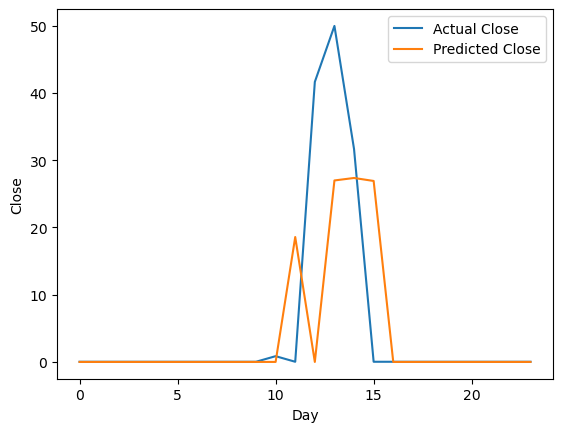

In [374]:
with torch.no_grad():
    predicted = best_model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train[0:24, 0, :], label='Actual Close')
plt.plot(predicted[0:24, 0, :], label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [375]:
y_train.shape

torch.Size([8507, 24, 1])

In [376]:
predicted.shape

(8507, 24, 1)

In [377]:
test_predictions = best_model(X_test.to(device)).detach().cpu().numpy()

In [378]:
test_predictions.shape

(1064, 24, 1)

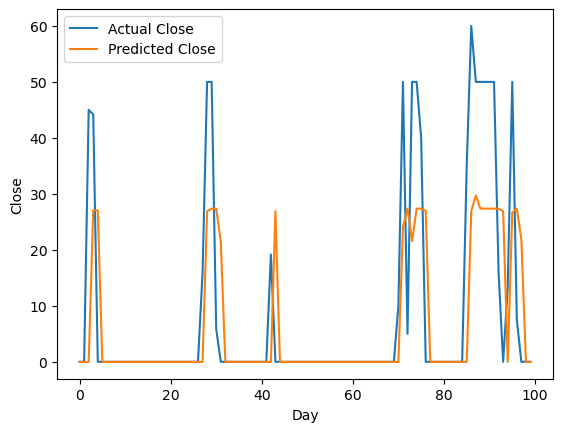

In [381]:
plt.plot(y_test[0:100, 0, :], label='Actual Close')
plt.plot(test_predictions[0:100, 0, :], label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()